# Charleston Shipping Lanes Risk Analysis

### Research Question

> Presently, there are no recommended lanes off Charleston. Would recommended lane/s reduce the relative risk of interactions between commercial vessels and right whales? Can it be determined?  If so, what is the expected reduction in risk of interactions and where should the lanes be placed? 

### Modeling Approach

Following Fonnesbeck *et al.* (2008), we will construct a predictive model of right whale encounter that is based on existing aerial survey data and relevant environmental predictors of whale habitat use, such as bathymetry and water temperature. This model will be used as a tool to identify a shipping lane designation that minimizes risk to the migratory northern right whale population.

The metric for risk for a particular lane designation will be the expected encounter rate of whale groups over the total area defined by any candidate lane. To avoid having to account for small-scale factors related to the interaction of whales and ships, risk will be estimated at a relatively coarse scale. Specifically, I will estimate the expected occurrence probability of whale groups over the cells of a 3 x 3 nmi grid in the southern part of the study area, and a 4 x 4 nmi grid in the north.

A key component of the modeling approach is the estimating the rate of encounter with whale groups in each grid cell. These estimates are informed by aerial survey data, which includes both sightings and on-watch effort. The key parameter of interest is the encounter rate, which we will use to model the survey encounters as a Poisson random variable, using the survey effort as an offset.

Because we are interested in identifying static lanes that do not change month-to-month, we will ignore the temporal dynamics of whale occurrence over the calving season, and pool the data regardless of month or year. This will greatly simplify the modeling and provide estimates that are based on overall whale habitat use.

To aid the predictive performance of the model, we will use covariates to estimate encounter rates; specifically, we will use the distance to the 22C isotherm and mean grid cell depth as non-parametric regression terms to predict whale encounters. This will allow for arbitrary non-linear relationships between either covariate and whale habitat use.

To account for spatial autocorrelation, we included a conditional auto-covariance function for the cells of the habitat grid, allowing information from adjacent grid cells to help inform one another, thereby improving model estimates. Observations among nearby cells are likely not independent, with whales sighted in one cell being very likely to visit adjacent cells within any 2-week period characterized by the aggregated survey data.

External constraints on the identification of an optimal line may include factors such as a maximum distance to port and a minimum lane width.

![lanes](http://d.pr/i/1lniv+)

## Data import and cleanup

In [1]:
%matplotlib inline
import matplotlib
import pylab as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from pyproj import Proj, transform
from datetime import date

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape

from itertools import chain

import urllib

import geopandas as gpd
from geopandas.tools import sjoin

Import ship transits to GeoDataFrame

In [2]:
transits = gpd.GeoDataFrame.from_file('data/transits.shp').replace({-999: None})

In [3]:
transits.head()

,CALLSIGN,FLAG,FLAG_TYPE,IMO,LOA,MMSI,NAME,SOV,TR_END,TR_HRS,TR_NMS,TR_PERIOD,TR_RECS,TR_START,TYPE,geometry
0,A8KM7,Liberia (Republic of),Foreign,9344033,183,636013087,Tverskoy Bridge,N,2011-11-01 00:41:35+00,0.68,8.1,2011-2012,18,2011-11-01 00:00:35+00,Tanker,(LINESTRING (-79.37621699999994 32.66900000000...
1,A8OS2,Liberia (Republic of),Foreign,9353266,269,636013695,Ym Elixir,N,2011-11-01 01:07:24+00,1.11,14.6,2011-2012,37,2011-11-01 00:00:46+00,Cargo,(LINESTRING (-79.44591699999995 32.60640000000...
2,WSW6620,United States of America,Domestic,0,18,367061140,Savannah,N,2011-11-01 00:37:12+00,0.61,11.7,2011-2012,28,2011-11-01 00:00:52+00,Pilot,(LINESTRING (-80.78339299999993 31.99384500000...
3,VRGA7,Hong Kong (Special Administrative Region of Ch...,Foreign,9231810,293,477634700,Zim New York,N,2011-11-01 07:45:17+00,7.74,17.3,2011-2012,182,2011-11-01 00:01:10+00,Cargo,(LINESTRING (-79.56774999999993 32.64030000000...
4,None,United States of America,Domestic,0,19,338108309,Lucky Star,N,2011-11-02 11:39:31+00,35.64,3.0,2011-2012,1467,2011-11-01 00:01:12+00,Pleasure,(LINESTRING (-79.75942499999991 32.80539700000...


Import and project habitat model data

In [4]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [5]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [6]:
upper_limit = 33
lower_limit = 31.683

In [7]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

Import nav channel layer

In [8]:
navchannel = gpd.GeoDataFrame.from_file('data/SHEP_navchannel.shp')

In [9]:
wgs84_crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}
navchannelWGS84 = navchannel.to_crs(wgs84_crs)

Import reaches data

In [10]:
reaches = gpd.GeoDataFrame.from_file('data/Charleston_Reaches_Post_45_Measures.shp')

In [11]:
reachesWGS84 = reaches.to_crs(wgs84_crs)

Import SMA

In [12]:
sma = gpd.GeoDataFrame.from_file("data/right_whale_sma_all/right_whale_SMA_all_po.shp").to_crs(wgs84_crs)

Set up base map of SC region for visualization

In [13]:
basemap_sc = Basemap(ax=None,
    llcrnrlon=-81.5,
    llcrnrlat=31.6,
    urcrnrlon=-77.5,
    urcrnrlat=33.2,
    resolution='i',
    epsg='4326')

In [66]:
charleston_lanes = gpd.GeoDataFrame.from_file('data/charleston_lanes.shp').to_crs(wgs84_crs)

In [72]:
savannah_lanes = gpd.GeoDataFrame.from_file('data/savannah_lanes.shp').to_crs(wgs84_crs)

Reaches locations

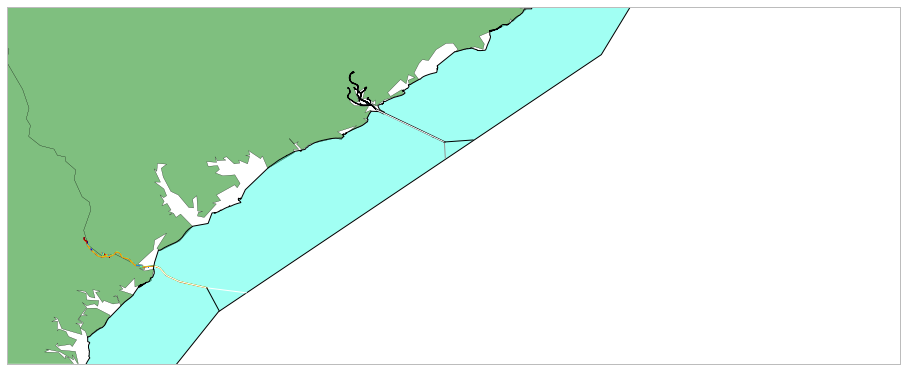

In [73]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
reachesWGS84.plot(axes=ax)
navchannelWGS84.plot(axes=ax)
sma.plot(axes=ax, alpha=0.4)
charleston_lanes.plot(axes=ax, colormap='Greys')
savannah_lanes.plot(axes=ax, colormap='Greys')

Import survey data and reproject to WGS84, then clip to area of interest.

In [15]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

Perform a merge of survey and habitat data

In [16]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [17]:
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [18]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

Buffer distance to shore

In [19]:
HabModel_merged = HabModel_merged[HabModel_merged.DistToShor>1000]

Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [20]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [21]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [22]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Create columns for 2-week period, year and time.

In [23]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor', 'MEAN_depth']
    n_fixed = len(cols)
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[n_fixed:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    if not month:
        year +=1
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [24]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [25]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

Add centroid coordinates to DataFrame

In [26]:
centroids = pd.DataFrame(working_data_long.geometry.apply(lambda x: dict(zip(['lat','lon'], np.ravel(x.centroid.xy)))).tolist(),
            index=working_data_long.index)

In [27]:
working_data_long = working_data_long.join(centroids)

Extract shipping exposure data, primarily by filtering out ineligible transits (Dec-Mar only).

In [28]:
transits['start_time'] = pd.to_datetime(transits.TR_START, 'D')
transits = transits[transits.start_time.apply(lambda x: (x.month in (12, 1, 2, 3)) and (x.date()<date(2013, 4, 1)))]

In [29]:
transit_times = transits.start_time.astype(object)

In [30]:
month_lookup = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

In [31]:
transits['time'] = transit_times.apply(lambda t: month_lookup[t.month] + str(t.year)[-2:] + ['a','b'][t.day>14])

Drop 2003, given the above, and recode year.

In [32]:
working_data_long['year'] = working_data_long.year - 1
working_data_long = working_data_long[working_data_long.year > 0]

In [33]:
working_data_long.head()

,quad_id,geometry,DistToShor,MEAN_depth,Eff,Grps,Whls,iso,sst,period,year,time,lat,lon
1210,4,"POLYGON ((-81.0638121503616 31.66385317360051,...",3863.834,-3.8095,15.846747,0,0,96621.078356,15.474,0,1,Dec04a,-81.093142,31.688897
1211,5,POLYGON ((-81.00520442711309 31.66387073674769...,9203.932,-5.6428,9.329810,1,2,92330.602241,15.940,0,1,Dec04a,-81.034518,31.688928
1212,6,POLYGON ((-80.94659696259843 31.66386003275813...,12499.129,-10.5952,11.931681,0,0,87950.966394,15.999,0,1,Dec04a,-80.975895,31.688932
1213,7,"POLYGON ((-80.8879895953431 31.66382227576766,...",16670.382,-12.4523,23.011338,0,0,83711.069405,16.519,0,1,Dec04a,-80.917272,31.688908
1214,8,POLYGON ((-80.82938237672916 31.66375760271118...,21411.103,-13.3809,23.367187,0,0,79633.234672,16.930,0,1,Dec04a,-80.858649,31.688856


Intersect polygons with transits and count transit intersections with each polygon as metric of ship traffic. This is a computationally intensive task, so the result will be saved to a shapefile, to be reused in later sessions. Flip `import_data` to `False` to re-generate intersections.

In [34]:
import_data = True

if not import_data:
    working_data_long['traffic'] = None
    for t in time_intervals:
        lines = [shape(g) for g in transits[transits.time==t].geometry]
        working_data_long.loc[working_data_long.time==t, 'traffic'] = working_data_long[
            working_data_long.time==t].geometry.apply(lambda x: sum([shape(x).intersects(g) for g in lines]))

    gpd.GeoDataFrame(working_data_long).to_file('working_data_long.shp')

In [35]:
if import_data:
    working_data_long = gpd.GeoDataFrame.from_file('working_data_long.shp')

Vessel traffic maps for an arbitrary period

In [36]:
basemap_sc.proj4string

'+lon_0=-79.5 +proj=eqc +units=m +a=6378137.0 +b=6356752.314245179 '

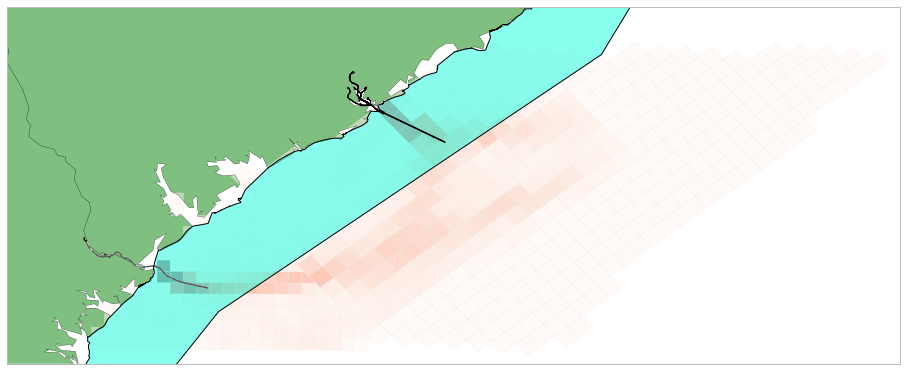

In [37]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

gpd.GeoDataFrame(working_data_long[working_data_long.time=='Jan13a']).plot(column='traffic', 
                                                                           colormap='Reds', linewidth=0, axes=ax)
reachesWGS84.plot(axes=ax, colormap='Greys')
navchannelWGS84.plot(axes=ax, colormap='Greys')
sma.plot(axes=ax)

In [38]:
dataset = working_data_long[~((working_data_long.Eff==0) & (working_data_long.Grps>0)) 
                            & working_data_long.sst.notnull() & working_data_long.MEAN_depth.notnull()]

# Include rows with positive effort
not_missing = dataset.Eff>0
dataset_surveyed = dataset[not_missing]
# Rows with zero effort is treated as missing data, to be predicted
missing_data = dataset[~not_missing]
centroids = dataset[['lat', 'lon']].values

Extract transits to each port by intersecting transits with reaches. Create a buffer around each reach, and identify traffic that enter the buffer.

In [39]:
charleston_buffered = reachesWGS84.geometry.buffer(.05).unary_union

In [40]:
charleston_traffic = transits[transits.geometry.intersects(charleston_buffered)]

In [41]:
savannah_buffered = navchannelWGS84.geometry.buffer(.05).unary_union

In [42]:
savannah_traffic = transits[transits.geometry.intersects(savannah_buffered)]

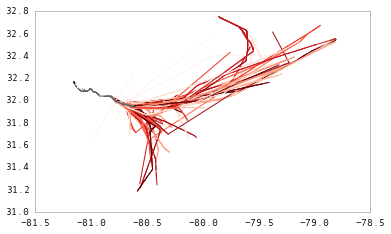

In [43]:
savannah_traffic.ix[:1600].plot(colormap='Reds')
navchannelWGS84.geometry.plot(colormap='Greys', alpha=0.1)

This map shows relative mean survey effort in the region.

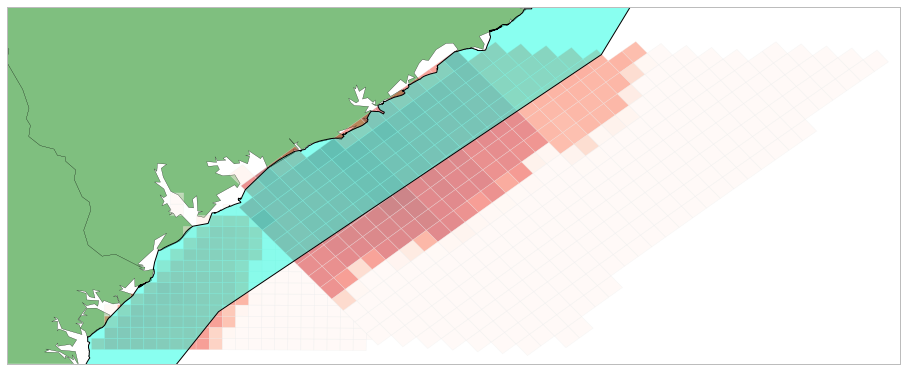

In [44]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()

df_geo = dataset.groupby('quad_id')

test = dataset[(dataset.year==5) & (dataset.period==5)].copy()
test = test.set_index(test.quad_id)

test['total_groups'] = df_geo['Grps'].sum()
test['mean_effort'] = df_geo['Eff'].mean()

basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
gpd.GeoDataFrame(test).plot(column='mean_effort', colormap='Reds', linewidth=0, axes=ax)
sma.plot(axes=ax)

## Conditional autoregressive model of whale occurrence

One of the key features of this analysis is the modeling of spatial autocorrelation via Gaussian processes. Since the number of surveys and sightings are limited, we need to borrow strength among the grid cells of the region, recognizing that an animal observed in one cell is likely to also be in neighboring cells within the same period. The Gaussian process models the spatial covariance directly, here estimating a risk surface of whale occurrence.

In [45]:
from pymc import Normal, Exponential, Uniform, Uninformative, Bernoulli, Poisson, Gamma
from pymc import Lambda, MCMC, invlogit, AdaptiveMetropolis, MCMC, normal_like
from pymc import potential, deterministic, stochastic, rnormal

Create mesh of area from grid centroids.

In [46]:
latmin, lonmin = centroids.min(0)
latmax, lonmax = centroids.max(0)
grid = np.meshgrid(np.linspace(lonmin, lonmax), np.linspace(latmin, latmax))
geo_mesh = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T*np.pi/180.

Extract columns of interest from dataset.

In [47]:
(lat, lon, period, year, sst, iso, traffic, depth) = dataset[
    ['lat', 'lon', 'period', 'year', 'sst', 'iso', 'traffic', 'MEAN_depth']].values.T
period = period.astype(int)

Use grouped dataset to extract summary values for each polygon

In [48]:
df_geo = dataset.groupby('quad_id')

In [49]:
# Columns that need to be averaged
data_summarized = df_geo[['lat', 'lon', 'sst', 'iso', 'MEAN_depth']].mean()
# Columns that need to be summed
data_summarized[['traffic', 'Grps', 'Whls', 'Eff']] = df_geo[['traffic', 'Grps', 'Whls', 'Eff']].sum()
data_summarized['geometry'] = df_geo['geometry'].first()
data_summarized.head()

,lat,lon,sst,iso,MEAN_depth,traffic,Grps,Whls,Eff,geometry
quad_id,,,,,,,,,,
4,-81.093142,31.688897,13.256247,119200.031023,-3.8095,4,0,0,1870.059657,"POLYGON ((-81.0638121503616 31.66385317360051,..."
5,-81.034518,31.688928,13.469918,114477.800710,-5.6428,13,1,2,2388.797729,POLYGON ((-81.00520442711309 31.66387073674769...
6,-80.975895,31.688932,13.618718,109732.472247,-10.5952,25,0,0,2389.803678,POLYGON ((-80.94659696259843 31.66386003275813...
7,-80.917272,31.688908,13.738225,104984.253630,-12.4523,33,2,3,2350.584436,"POLYGON ((-80.8879895953431 31.66382227576766,..."
8,-80.858649,31.688856,13.886081,100228.491291,-13.3809,40,1,1,2304.253170,POLYGON ((-80.82938237672916 31.66375760271118...


Confirm no missing values

In [50]:
data_summarized.isnull().sum()

lat           0
lon           0
sst           0
iso           0
MEAN_depth    0
traffic       0
Grps          0
Whls          0
Eff           0
geometry      0
dtype: int64

Distribution of effort across cells

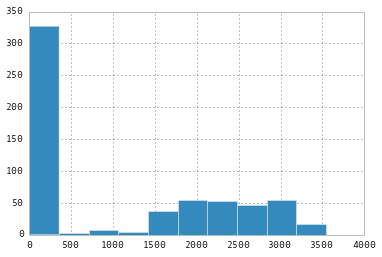

In [51]:
data_summarized.Eff.hist()

Remove unsurveyed polygons

In [52]:
data_surveyed = data_summarized[data_summarized.Eff>0]

Normalize SST, ISO and depth

In [53]:
normalize = lambda x: np.array((x - x.mean()) / x.std())

In [54]:
sst_norm = normalize(data_surveyed.sst)
iso_norm = normalize(data_surveyed.iso)
depth_norm = normalize(data_surveyed.MEAN_depth)

In [55]:
traffic = data_surveyed.traffic.values

In [56]:
groups, whales, effort = data_surveyed[['Grps', 'Whls', 'Eff']].values.T
year = year.astype(int)
groups = groups.astype(int)

Scale effort by a factor of 100 to avoid numerical issues

In [57]:
effort = effort/100.

Generate neighborhood matrix for all polygons, to be used in the first-order conditional autoregressive model.

In [58]:
data_gdf = gpd.GeoDataFrame(data_surveyed)

In [59]:
neighbors = np.array([data_gdf.geometry.touches(v).values for i, v in data_gdf.geometry.iteritems()])

We will be using a Gaussian radial basis function for the non-parametric regression terms describing the effects of isobath and depth on whale probability.

In [60]:
gaussian_rbf = lambda x, mu, l: np.exp(-np.abs(x - mu)**2 / l**2)

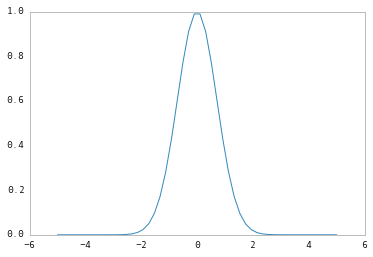

In [61]:
xrange = np.linspace(-5, 5)
plt.plot(xrange, [gaussian_rbf(x, 0, 1) for x in xrange])

### Non-parametric regression sub-model

In order to avoid making assumptions about the functional form of the relationship between spatial covariates (water depth and distance to 22-degree isotherm) and the encounter rate with whale groups. For each variable, we specify ten Student-t distributed basis functions that are evenly-spaced over the observed range of the variables. The parameters corresponding to each basis function are then weighted according to the distance from a given point to the center of the function, and added to form a coefficient. The result is a flexible, non-parametric function.

In [174]:
def rbf(name, x, n=10):
    
    # Number of basis functions for isobath effect
    h = np.linspace(x.min(), x.max(), 10)
    l = Exponential('l_%s' % name, 1, value=1)
    # RBF weights
    w = Lambda('w_%s' % name, lambda l=l: np.array([gaussian_rbf(i, h, l) for i in x]))
    
    σ = Gamma('σ_%s' % name, 0.5, 0.5, value=np.ones(n))
    τ = σ**-2

    β = Normal('β_%s' % name, 0, τ, value=np.zeros(n))
    τ_rbf = Exponential('τ_rbf_%s' % name, 1, value=1)
    
    @stochastic(name='rbf_%s' % name)
    def rbf(value=np.zeros(len(x)), β=β, w=w, τ=τ_rbf):
        m = w.dot(β)
        return normal_like(value, m, τ)
    
    @deterministic(name='rbf_eval_%s' % name)
    def rbf_eval(β=β, τ=τ_rbf, l=l):
        wts = np.array([gaussian_rbf(i, h, l) for i in h])
        m = wts.dot(β)
        return rnormal(m, τ)
    
    return locals()

### Conditional autoregressive (CAR) model

In order to allow for the spatial autocorrelation of whale group observations, we implemented a first-order conditional autoregressive model, which expresses the effect in the current cell $k$ as a Gaussian-distributed random variable, with a mean equal to the weighted average of the direct neighbors (typically 8 cells). 

![CAR](http://d.pr/i/11AkN+)

Here, we equally weight all neighbors, $w_{ki} = 1 \, \forall \, i,k$.

In [175]:
def rbf_car_model():
    
    intercept = Normal('intercept', 0, 0.001, value=0)
    
    rbf_iso = rbf('iso', iso_norm)
    
    rbf_depth = rbf('depth', depth_norm)
    
    # CAR component
    ϕ = Uninformative('ϕ', value=np.zeros(len(groups)))
    τ_car = Exponential('τ_car', 1, value=1)
    
    @potential
    def car(ϕ=ϕ, τ=τ_car):
        
        n = neighbors.sum(0).astype(float)
        
        return normal_like(ϕ, ϕ.dot(neighbors)/n, n*τ)

    # Occurrence rate
    @deterministic
    def θ(β0=intercept, β1=rbf_depth['rbf'], β2=rbf_iso['rbf'], phi=ϕ):
        return np.exp(β0 + β1 + β2 + phi) 

    λ = Lambda('λ', lambda θ=θ: θ * effort)
        
    # Likelihood
    group_obs = Poisson('group_obs', λ, value=groups, observed=True)
    
    risk = Lambda('risk', lambda theta=θ: theta*traffic)
               
    return locals()

Instantiate and run MCMC model

In [176]:
M = MCMC(rbf_car_model())

# Use adaptive Metropolis to improve mixing for some variables
M.use_step_method(AdaptiveMetropolis, M.__dict__['rbf_iso']['σ'])
M.use_step_method(AdaptiveMetropolis, M.__dict__['rbf_depth']['σ'])
M.use_step_method(AdaptiveMetropolis, M.ϕ)

In [177]:
M.sample(200000, 190000)

 [-----------------100%-----------------] 200000 of 200000 complete in 1474.6 sec

/Users/fonnescj/GitHub/pymc/pymc/StepMethods.py:1272: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


## Model output

The following graphical summaries show the posterior distribution of key parameters.


Basis function variances for isobath effect

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


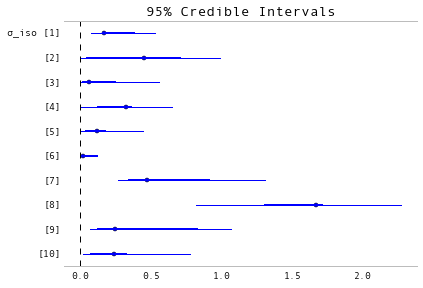

In [178]:
from pymc import Matplot

Matplot.summary_plot(M.__dict__['rbf_iso']['σ'])

Plotting τ_rbf_iso


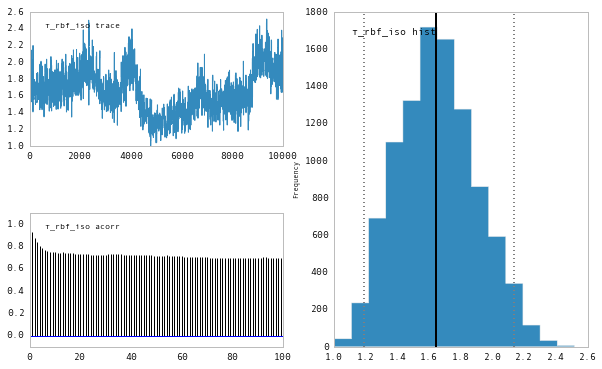

In [179]:
Matplot.plot(M.__dict__['rbf_iso']['τ_rbf'])

Plotting intercept


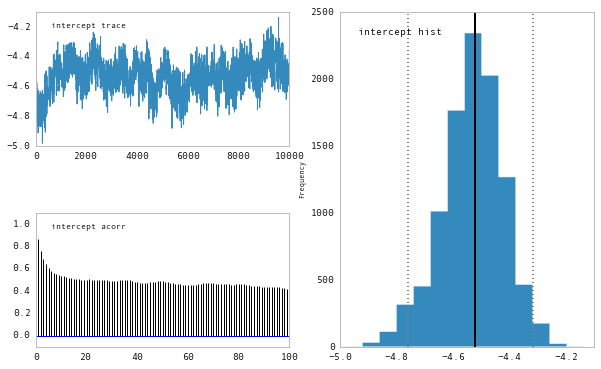

In [180]:
Matplot.plot(M.intercept)

Non-parametric depth effect (recall that depth is expressed in negative values in the dataset)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


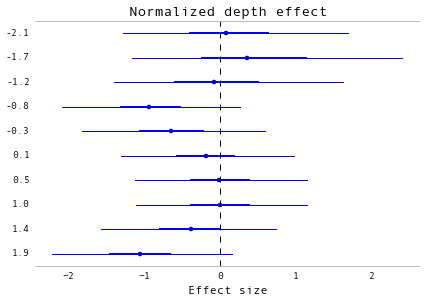

In [195]:
Matplot.summary_plot(M.__dict__['rbf_depth']['rbf_eval'], 
                     custom_labels=np.linspace(iso_norm.min(), iso_norm.max(), 10).round(1).astype(str),
                    xlab='Effect size', main='Normalized depth effect')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


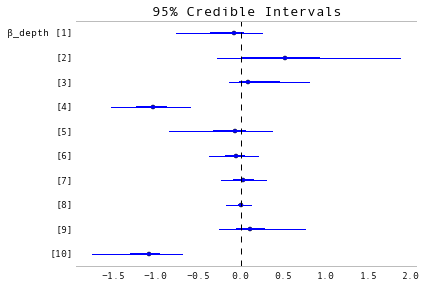

In [194]:
Matplot.summary_plot(M.__dict__['rbf_depth']['β'])

Non-parametric isotherm effect:

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


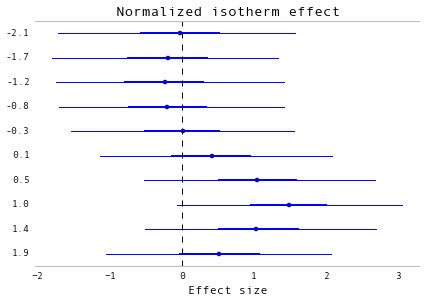

In [196]:
Matplot.summary_plot(M.__dict__['rbf_iso']['rbf_eval'],
                     custom_labels=np.linspace(iso_norm.min(), iso_norm.max(), 10).round(1).astype(str),
                    xlab='Effect size', main='Normalized isotherm effect')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


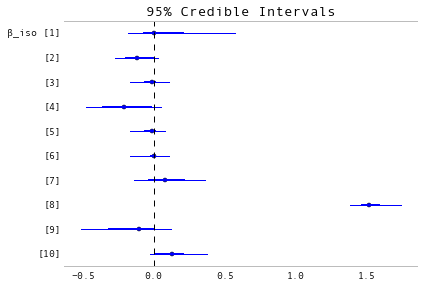

In [197]:
Matplot.summary_plot(M.__dict__['rbf_iso']['β'])

In [198]:
data_surveyed['p_pred'] = M.θ.stats()['mean']

In [170]:
def plot_series(series, data=data_surveyed, cmap='Reds'):
    
    gdf = gpd.GeoDataFrame(data)
    
    fig = plt.figure(figsize=(16,12))
    ax = plt.gca()
    basemap_sc.drawstates(linewidth=0.15)
    basemap_sc.drawcoastlines(linewidth=0.25)
    basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
    gdf.plot(column=series, colormap=cmap, linewidth=0, axes=ax)
    navchannelWGS84.plot(column='Color', axes=ax)
    reachesWGS84.plot(column='reachCode', axes=ax)

Expected encounter rate

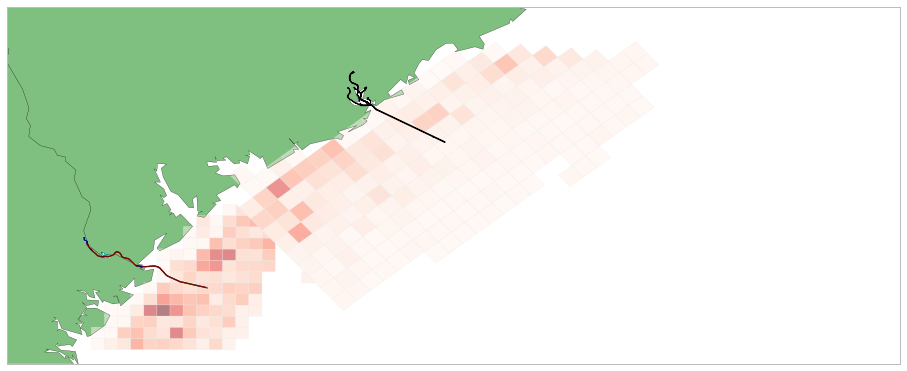

In [171]:
plot_series('p_pred')

Estimate of risk based on past traffic

In [104]:
data_surveyed['risk'] = M.risk.stats()['mean']

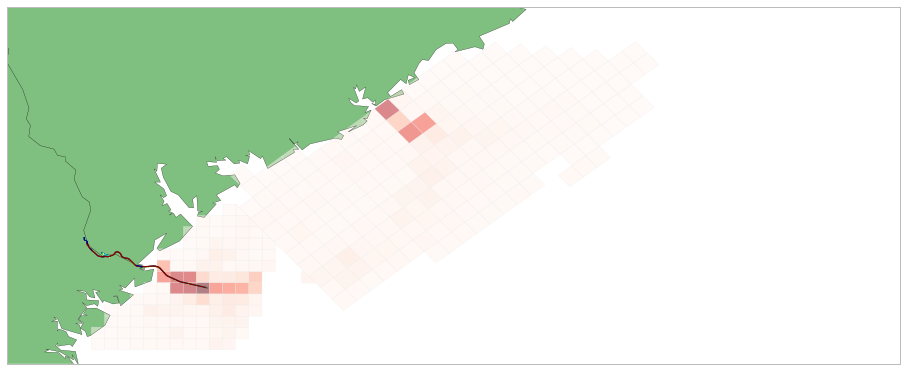

In [111]:
plot_series('risk')

Spatial autocorrelation effect

In [106]:
data_surveyed['phi'] = M.ϕ.stats()['mean']

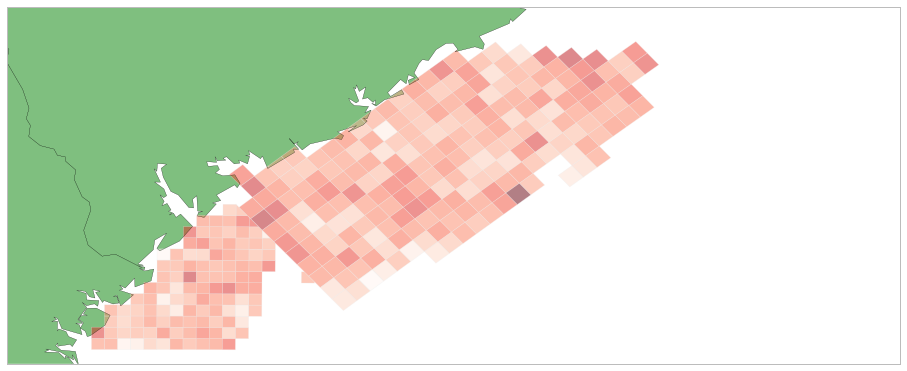

In [107]:
plot_series('phi')

Traffic on the logarithmic scale

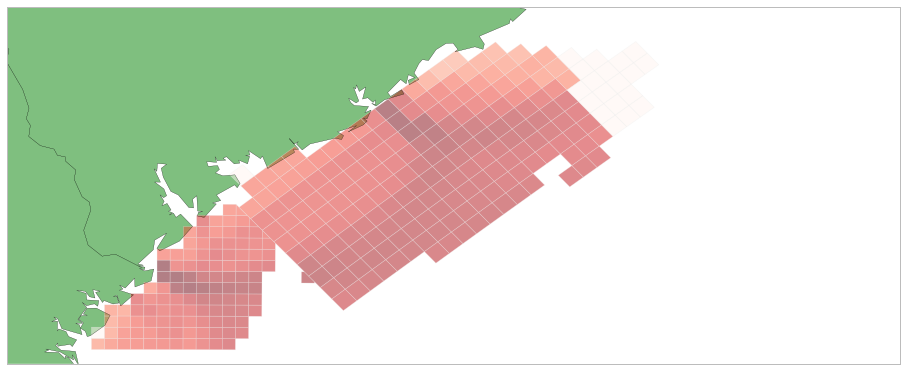

In [108]:
data_surveyed['log_traffic'] = np.log(data_surveyed.traffic + 0.01)

plot_series('log_traffic')

Total past traffic relative ot reaches.

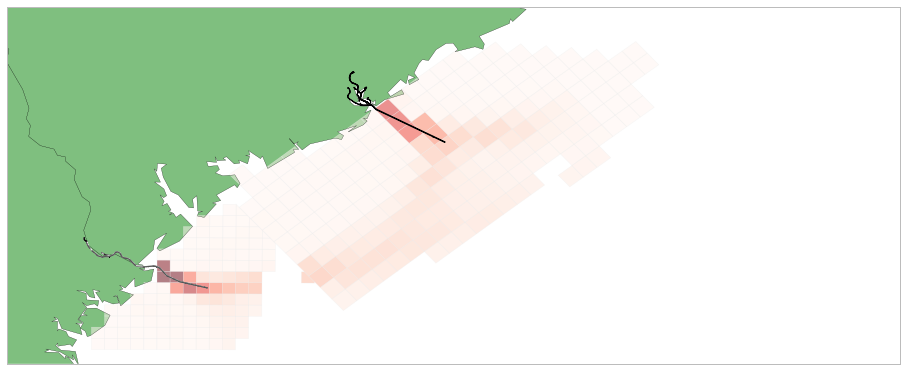

In [155]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

gpd.GeoDataFrame(data_surveyed).plot(column='traffic', colormap='Reds', linewidth=0, axes=ax)
reachesWGS84.plot(axes=ax, colormap='Greys')
navchannelWGS84.plot(axes=ax, colormap='Greys')